In [ ]:
!unzip ShanghaiTechPartA.zip

Archive:  ShanghaiTechPartA.zip
   creating: ShanghaiTechPartA/
   creating: ShanghaiTechPartA/part_A/
   creating: ShanghaiTechPartA/part_A/test_data/
   creating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_1.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_10.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_100.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_101.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_102.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_103.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_104.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_105.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_106.h5  
  inflating: ShanghaiTechPartA/part_A/test_data/ground-truth-h5/IMG_107.h5  
  inflating: Sha

--------------------------------------------------
Using device: cpu
Dataset Debug Info:
Image directory: /content/ShanghaiTechPartA/part_A/train_data/images
Ground truth directory: /content/ShanghaiTechPartA/part_A/train_data/ground_truth
Image dir exists: True
GT dir exists: True
Sample image files: ['IMG_15.jpg', 'IMG_153.jpg', 'IMG_173.jpg', 'IMG_223.jpg', 'IMG_229.jpg']
Sample GT files: ['GT_IMG_263.mat', 'GT_IMG_17.mat', 'GT_IMG_191.mat', 'GT_IMG_55.mat', 'GT_IMG_186.mat']
Keys in GT_IMG_263.mat: ['__header__', '__version__', '__globals__', 'image_info']
Points shape (image_info): (658, 2)
Training samples: 300
Testing samples: 182
Model created with 7765985 parameters
Starting training...
Epoch 1/20, Batch 0/19, Loss: 10880823.0000, MAE: 9213.70
Epoch 1/20, Batch 10/19, Loss: 1494908.3750, MAE: 3540.04
Epoch 1/20:
Train Loss: 2777782.1299, Train MAE: 4367.03
Val Loss: 31313411.0000, Val MAE: 17663.10
--------------------------------------------------
Epoch 2/20, Batch 0/19, Loss

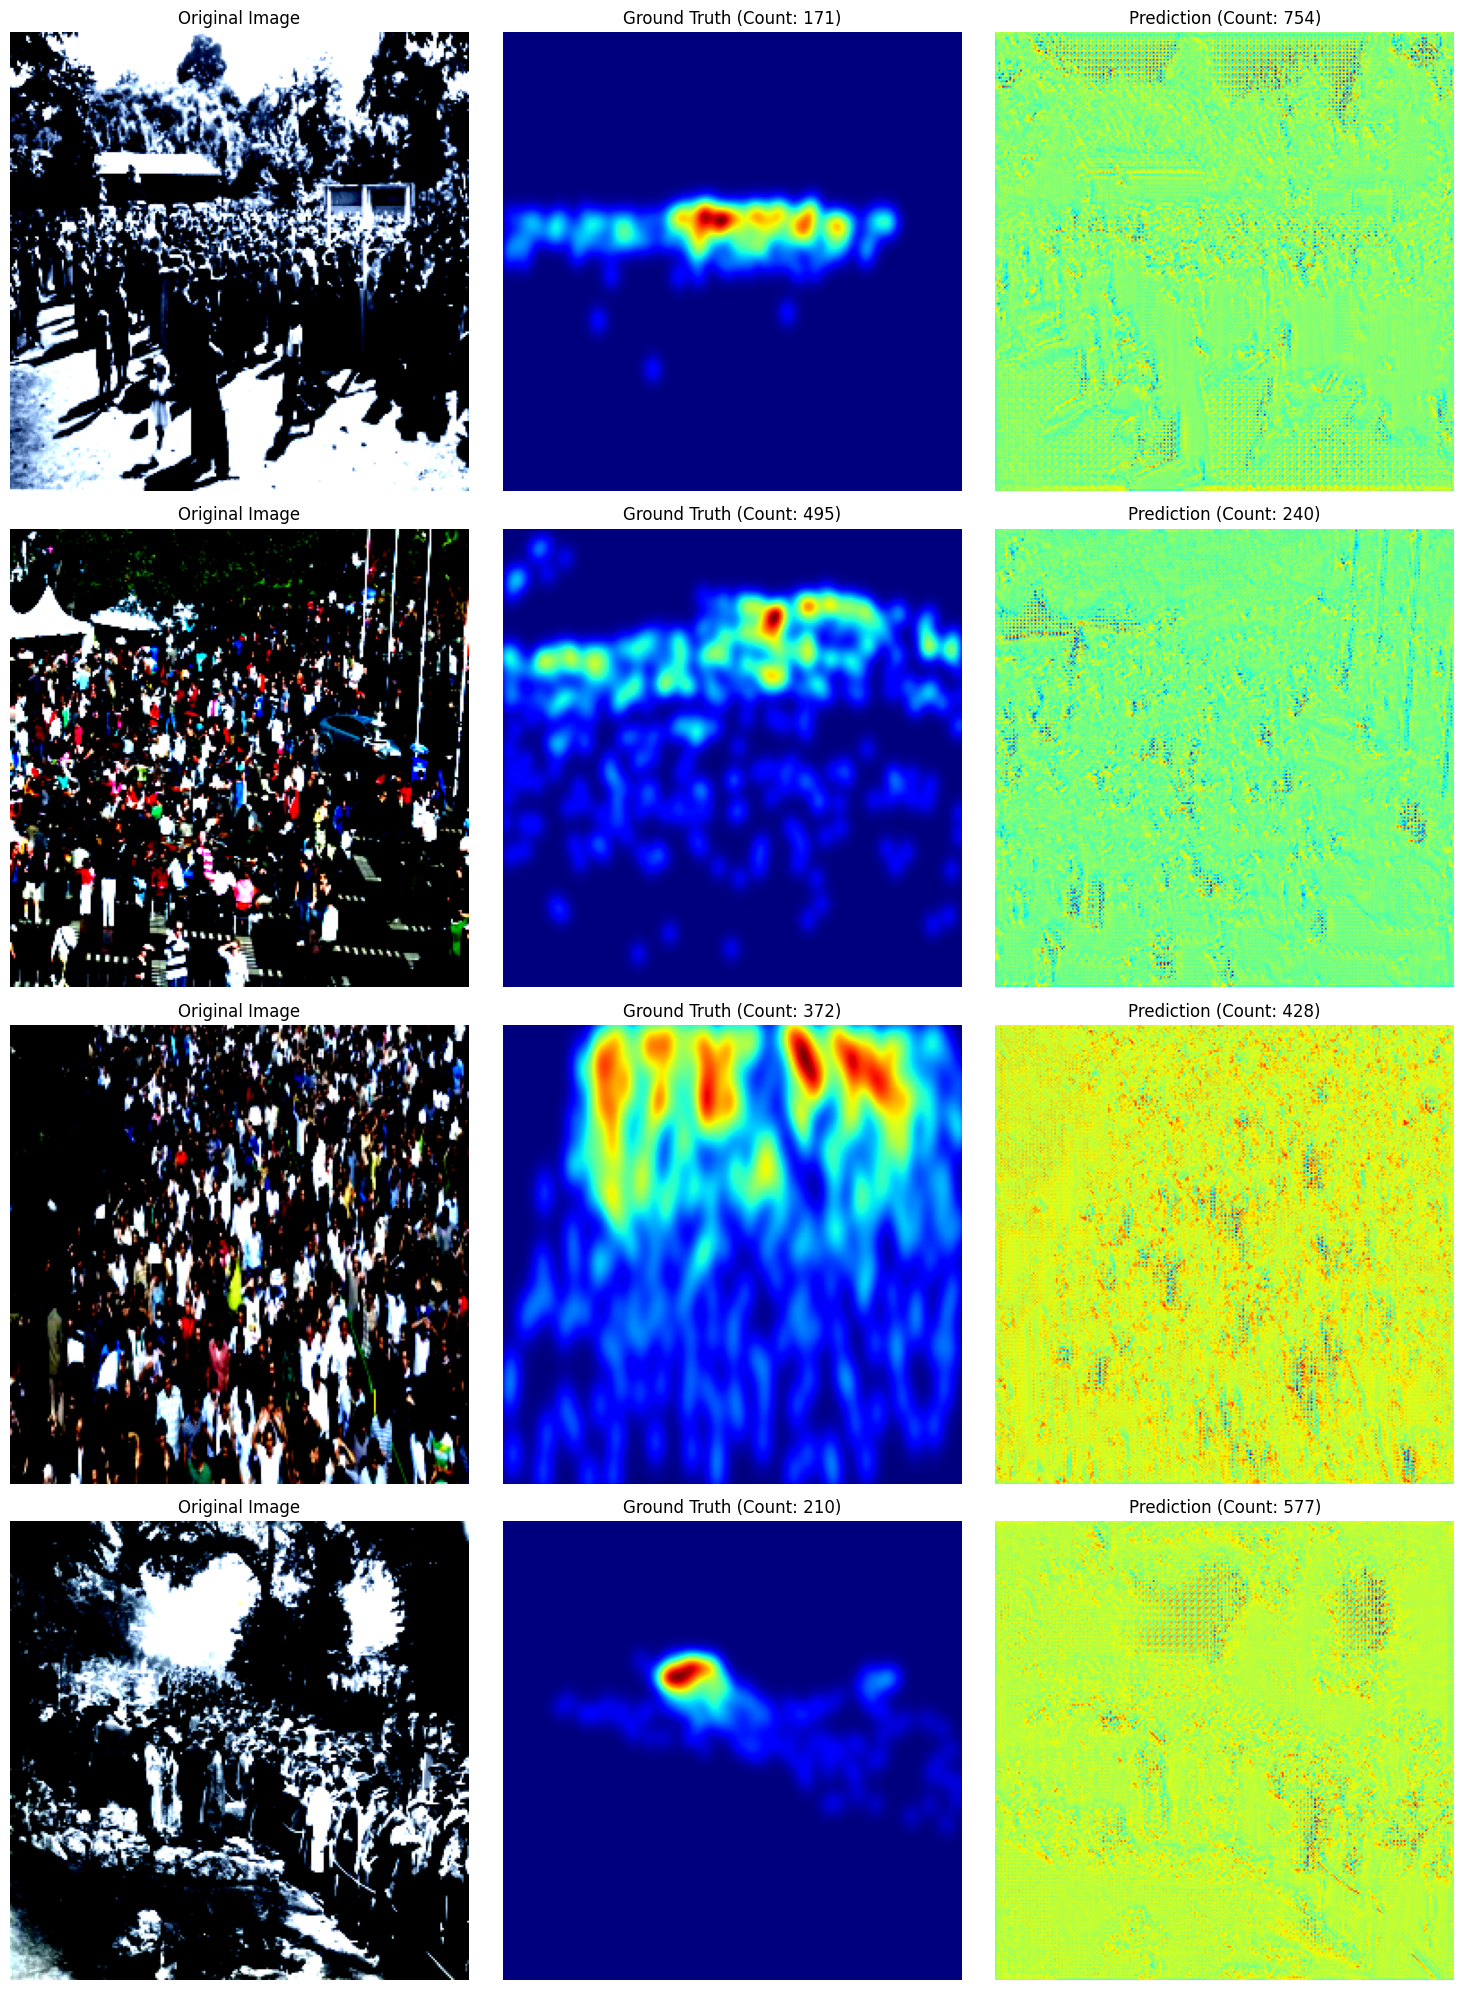

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import scipy.io as sio
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import json

class UNet(nn.Module):
    """Lightweight U-Net architecture for density map regression - Memory Optimized"""

    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Reduced channel sizes for memory efficiency
        # Encoder (downsampling path)
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck - reduced from 1024 to 512
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (upsampling path)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(512, 256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        # Final output layer
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        """Double convolution block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Final output
        out = self.final_conv(dec1)
        return out

class ShanghaiDataset(Dataset):
    """Dataset class for ShanghaiTech crowd counting dataset"""

    def __init__(self, data_root, part='A', phase='train', transform=None, target_size=(256, 256)):
        """
        Args:
            data_root: Root directory of ShanghaiTech dataset
            part: 'A' or 'B' for different parts of the dataset
            phase: 'train' or 'test'
            transform: Optional transform to be applied on images
            target_size: Resize images to this size (reduced for memory efficiency)
        """
        self.data_root = data_root
        self.part = part
        self.phase = phase
        self.transform = transform
        self.target_size = target_size

        # Construct paths
        self.img_dir = os.path.join(data_root, f'part_{part}', f'{phase}_data', 'images')
        self.gt_dir = os.path.join(data_root, f'part_{part}', f'{phase}_data', 'ground_truth')

        # Get all image filenames
        self.img_names = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        self.img_names.sort()

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Load ground truth annotations - handle different naming conventions
        # Try multiple possible naming patterns for ground truth files
        possible_gt_names = [
            'GT_' + img_name.replace('.jpg', '.mat'),
            img_name.replace('.jpg', '.mat'),
            img_name.replace('IMG_', 'GT_IMG_').replace('.jpg', '.mat'),
            'GT_' + img_name,
            img_name.replace('.jpg', '_ann.mat')
        ]

        gt_path = None
        mat_data = None

        # Try to find the correct ground truth file
        for gt_name in possible_gt_names:
            potential_gt_path = os.path.join(self.gt_dir, gt_name)
            if os.path.exists(potential_gt_path):
                gt_path = potential_gt_path
                break

        if gt_path is None:
            # List available ground truth files for debugging
            available_files = os.listdir(self.gt_dir)[:5]  # Show first 5 files
            raise FileNotFoundError(
                f"Could not find ground truth file for image: {img_name}\n"
                f"Tried: {possible_gt_names}\n"
                f"Available GT files (first 5): {available_files}\n"
                f"GT directory: {self.gt_dir}"
            )

        # Load matlab file with annotations
        try:
            mat_data = sio.loadmat(gt_path)
            # Try different possible data structures in the .mat file
            if 'image_info' in mat_data:
                points = mat_data['image_info'][0, 0][0, 0][0]
            elif 'annPoints' in mat_data:
                points = mat_data['annPoints']
            elif 'annotation' in mat_data:
                points = mat_data['annotation']
            else:
                # Print available keys for debugging
                print(f"Available keys in {gt_name}: {list(mat_data.keys())}")
                points = []
        except Exception as e:
            print(f"Error loading {gt_path}: {e}")
            points = []

        # Handle empty or malformed point data
        if points is None or len(points) == 0:
            points = np.array([]).reshape(0, 2)
        else:
            points = np.array(points)
            if points.ndim == 1 and len(points) > 0:
                points = points.reshape(-1, 2)

        # Create density map
        density_map = self.create_density_map(img.size, points)

        # Resize image and density map
        img = img.resize(self.target_size, Image.BILINEAR)
        density_map = self.resize_density_map(density_map, self.target_size)

        # Apply transforms
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Convert density map to tensor
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        return img, density_map

    def create_density_map(self, img_size, points, sigma=15):
        """
        Create density map from point annotations using Gaussian kernels

        The ShanghaiTech dataset provides point annotations (head positions) in .mat files.
        We convert these points into density maps by:
        1. Creating a binary map with 1s at head positions
        2. Applying Gaussian blur to create smooth density distributions
        3. The sum of the density map equals the number of people
        """
        w, h = img_size
        density_map = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density_map

        # Place point annotations on the density map
        for point in points:
            x, y = int(point[0]), int(point[1])
            if 0 <= x < w and 0 <= y < h:
                density_map[y, x] = 1

        # Apply Gaussian filter to create smooth density distribution
        # sigma controls the spread - larger sigma = more spread out
        density_map = gaussian_filter(density_map, sigma=sigma, mode='constant')

        return density_map

    def resize_density_map(self, density_map, target_size):
        """Resize density map while preserving the total count"""
        h, w = density_map.shape
        target_w, target_h = target_size

        # Calculate scaling factors
        scale_x = target_w / w
        scale_y = target_h / h

        # Resize using scipy
        from scipy.ndimage import zoom
        resized_density = zoom(density_map, (scale_y, scale_x), order=1)

        # Normalize to preserve total count
        original_count = np.sum(density_map)
        resized_count = np.sum(resized_density)

        if resized_count > 0:
            resized_density = resized_density * (original_count / resized_count)

        return resized_density

class CrowdCountingLoss(nn.Module):
    """Combined loss function for crowd counting"""

    def __init__(self, mse_weight=1.0, count_weight=0.1):
        super(CrowdCountingLoss, self).__init__()
        self.mse_weight = mse_weight
        self.count_weight = count_weight
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        # Density map MSE loss
        density_loss = self.mse_loss(pred, target)

        # Count loss (difference in total counts)
        pred_count = torch.sum(pred, dim=(1, 2, 3))
        target_count = torch.sum(target, dim=(1, 2, 3))
        count_loss = self.mse_loss(pred_count, target_count)

        total_loss = self.mse_weight * density_loss + self.count_weight * count_loss

        return total_loss, density_loss, count_loss

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, device='cuda'):
    """Training function with memory optimization"""

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    criterion = CrowdCountingLoss()

    # Enable mixed precision training for memory efficiency
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler() if device.type == 'cuda' else None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        for batch_idx, (images, targets) in enumerate(train_loader):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            # Use mixed precision if CUDA is available
            if scaler is not None:
                with autocast():
                    outputs = model(images)
                    loss, density_loss, count_loss = criterion(outputs, targets)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss, density_loss, count_loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

            # Calculate MAE (Mean Absolute Error) for counting
            with torch.no_grad():
                pred_count = torch.sum(outputs, dim=(1, 2, 3))
                target_count = torch.sum(targets, dim=(1, 2, 3))
                mae = torch.mean(torch.abs(pred_count - target_count))
                train_mae += mae.item()

            # Clear cache periodically to prevent memory buildup
            if batch_idx % 10 == 0:
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, MAE: {mae.item():.2f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)

                if scaler is not None:
                    with autocast():
                        outputs = model(images)
                        loss, _, _ = criterion(outputs, targets)
                else:
                    outputs = model(images)
                    loss, _, _ = criterion(outputs, targets)

                val_loss += loss.item()

                pred_count = torch.sum(outputs, dim=(1, 2, 3))
                target_count = torch.sum(targets, dim=(1, 2, 3))
                mae = torch.mean(torch.abs(pred_count - target_count))
                val_mae += mae.item()

        # Clear cache after validation
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Update learning rate
        scheduler.step()

        # Record losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_val_mae = val_mae / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.2f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.2f}')
        print('-' * 50)

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, f'crowd_counting_unet_epoch_{epoch+1}.pth')

    return train_losses, val_losses

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluation function"""
    model.eval()
    total_mae = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            pred_count = torch.sum(outputs, dim=(1, 2, 3))
            target_count = torch.sum(targets, dim=(1, 2, 3))

            mae = torch.sum(torch.abs(pred_count - target_count))
            mse = torch.sum((pred_count - target_count) ** 2)

            total_mae += mae.item()
            total_mse += mse.item()
            num_samples += images.size(0)

    avg_mae = total_mae / num_samples
    avg_mse = np.sqrt(total_mse / num_samples)

    print(f'Test Results:')
    print(f'MAE: {avg_mae:.2f}')
    print(f'RMSE: {avg_mse:.2f}')

    return avg_mae, avg_mse

def visualize_results(model, dataset, device='cuda', num_samples=4):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            img, target = dataset[i]
            img_batch = img.unsqueeze(0).to(device)

            # Get prediction
            pred = model(img_batch)
            pred = pred.squeeze().cpu().numpy()
            target = target.squeeze().numpy()

            # Convert image tensor to numpy for visualization
            img_np = img.permute(1, 2, 0).numpy()

            # Plot original image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f'Original Image')
            axes[i, 0].axis('off')

            # Plot ground truth density map
            axes[i, 1].imshow(target, cmap='jet')
            axes[i, 1].set_title(f'Ground Truth (Count: {np.sum(target):.0f})')
            axes[i, 1].axis('off')

            # Plot predicted density map
            axes[i, 2].imshow(pred, cmap='jet')
            axes[i, 2].set_title(f'Prediction (Count: {np.sum(pred):.0f})')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    def debug_dataset_structure(data_root, part='A', phase='train'):
      """Debug function to understand dataset structure"""

      img_dir = os.path.join(data_root, f'part_{part}', f'{phase}_data', 'images')
      gt_dir = os.path.join(data_root, f'part_{part}', f'{phase}_data', 'ground_truth')

      print(f"Dataset Debug Info:")
      print(f"Image directory: {img_dir}")
      print(f"Ground truth directory: {gt_dir}")
      print(f"Image dir exists: {os.path.exists(img_dir)}")
      print(f"GT dir exists: {os.path.exists(gt_dir)}")

      if os.path.exists(img_dir):
          img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')][:5]
          print(f"Sample image files: {img_files}")

      if os.path.exists(gt_dir):
          gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.mat')][:5]
          print(f"Sample GT files: {gt_files}")

          # Try to load one GT file to understand structure
          if gt_files:
              sample_gt_path = os.path.join(gt_dir, gt_files[0])
              try:
                  mat_data = sio.loadmat(sample_gt_path)
                  print(f"Keys in {gt_files[0]}: {list(mat_data.keys())}")

                  # Try to access points in different ways
                  if 'image_info' in mat_data:
                      try:
                          points = mat_data['image_info'][0, 0][0, 0][0]
                          print(f"Points shape (image_info): {np.array(points).shape}")
                      except:
                          print("Could not access points via image_info")

                  if 'annPoints' in mat_data:
                      points = mat_data['annPoints']
                      print(f"Points shape (annPoints): {np.array(points).shape}")

              except Exception as e:
                  print(f"Error loading sample GT file: {e}")

    print("-" * 50)

# Main execution
if __name__ == "__main__":
    # Configuration - Optimized for memory efficiency
    DATA_ROOT = "/content/ShanghaiTechPartA"  # Update this path
    PART = 'A'  # or 'B'
    BATCH_SIZE = 16  # Reduced from 4 to 2 for memory efficiency
    NUM_EPOCHS = 20
    LEARNING_RATE = 1e-4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {DEVICE}")

    # Clear CUDA cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"GPU Memory Available: {torch.cuda.memory_reserved(0) / 1e9:.1f} GB")

    # Debug dataset structure first
    debug_dataset_structure(DATA_ROOT, PART, 'train')

    # Expected ShanghaiTech dataset structure:
    """
    ShanghaiTech/
    ├── part_A/ (or part_B/)
    │   ├── train_data/
    │   │   ├── images/           # Training images (.jpg files)
    │   │   └── ground_truth/     # Ground truth annotations (.mat files)
    │   │       ├── GT_IMG_1.mat  # Contains point annotations
    │   │       ├── GT_IMG_2.mat
    │   │       └── ...
    │   └── test_data/
    │       ├── images/           # Test images (.jpg files)
    │       └── ground_truth/     # Ground truth annotations (.mat files)
    │           ├── GT_IMG_1.mat
    │           ├── GT_IMG_2.mat
    │           └── ...

    Each .mat file contains:
    - image_info[0,0][0,0][0]: Array of [x,y] coordinates for each person's head
    - These points are converted to density maps on-the-fly during training
    """

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = ShanghaiDataset(DATA_ROOT, part=PART, phase='train', transform=transform)
    test_dataset = ShanghaiDataset(DATA_ROOT, part=PART, phase='test', transform=transform)

    # Create data loaders with memory optimization
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=2, pin_memory=True if DEVICE.type=='cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=True if DEVICE.type=='cuda' else False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Create model
    model = UNet(in_channels=3, out_channels=1)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    # Train model
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, test_loader,
                                         num_epochs=NUM_EPOCHS,
                                         learning_rate=LEARNING_RATE,
                                         device=DEVICE)

    # Evaluate model
    print("Evaluating model...")
    mae, rmse = evaluate_model(model, test_loader, device=DEVICE)

    # Save final model
    torch.save(model.state_dict(), 'crowd_counting_unet_final.pth')
    print("Model saved!")

    # Visualize some results
    visualize_results(model, test_dataset, device=DEVICE)